<a href="https://colab.research.google.com/github/AndrewEPrince/codespaces-blank/blob/main/BallsNetUI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#@title Installations
!pip install tensorflow --upgrade -q
!pip install keras --upgrade -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


In [2]:
#@title Imports
import requests
import json
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from keras.models import load_model
from keras import backend as K

from joblib import load

!git clone https://github.com/AndrewEPrince/codespaces-blank.git

2.15.0
fatal: destination path 'codespaces-blank' already exists and is not an empty directory.


In [3]:
#@title Load Model
K.clear_session()

model = load_model("/content/codespaces-blank/ballsnet1.2.h5")
scaler = load(open("/content/codespaces-blank/ballsnet_scaler.joblib", "rb"))

In [8]:
#@title Get Data From API
#@markdown Enter a URL for a group
url = "https://ballchasing.com/api/groups/12-2-tourney-groups-mker46age6/" #@param {type: "string"}
#@markdown Enter your API key
api_key = '8wjl1G9d8V8Ymfju7hH8K57aKNUiNhYe5oOYOxNr' #@param {type: "string"}
headers = {'Authorization': api_key }
response = requests.get(url, headers=headers)
data = json.loads(response.text)
df = pd.json_normalize(data)

In [9]:
#@title Parse Data
for i in range(len(df)):
  data_df = pd.DataFrame(pd.json_normalize(df.iloc[i]['players']))
  for j in range(len(data_df)):
    temp_df = pd.DataFrame(data_df.iloc[j]).T
    player_df = temp_df if i == 0 and j == 0 else pd.concat([player_df, temp_df])

display(player_df)

temp_player_df = player_df.drop(columns=['platform'], axis=1)
temp_player_df = temp_player_df.drop(columns=['id'], axis=1)
names = temp_player_df['name']
temp_player_df = temp_player_df.drop(columns=['name'], axis=1)
temp_player_df = temp_player_df.drop(columns=['team'], axis=1)
temp_player_df = temp_player_df.drop(columns=['cumulative.games'], axis=1)

x = np.asarray(temp_player_df)

x_scaled = scaler.transform(x)

,platform,id,name,team,cumulative.games,cumulative.wins,cumulative.win_percentage,cumulative.play_duration,cumulative.core.shots,cumulative.core.shots_against,...,game_average.positioning.time_farthest_from_ball,game_average.positioning.percent_defensive_third,game_average.positioning.percent_offensive_third,game_average.positioning.percent_neutral_third,game_average.positioning.percent_defensive_half,game_average.positioning.percent_offensive_half,game_average.positioning.percent_behind_ball,game_average.positioning.percent_infront_ball,game_average.demo.inflicted,game_average.demo.taken
0,Steam,76561198102062913,Andrew,NOVA,14,8,57.142857,4961,39,105,...,107.12144,44.81746,24.912014,30.270529,60.070953,39.929043,67.95556,32.04444,1.214286,0.857143
1,Epic,14417a5fe6704fe7b80ad945fc87e273,ChaMP0.,PHEONIX,7,3,42.857143,2438,18,58,...,114.828575,51.74808,17.477097,30.774824,68.19472,31.805285,70.59572,29.404285,0.428571,0.857143
2,Epic,3c49a32de9f949329713773dd89eeb51,Irozuh-,PHEONIX,1,0,0.0,350,0,10,...,121.7,56.6323,20.7263,22.641403,69.11359,30.88642,68.54625,31.45375,0.0,1.0
3,Epic,4ef5fe96450e462ca25a8046b01ced65,Jolly Smith,T-BIRDS,7,3,42.857143,2523,18,61,...,106.685715,52.65885,17.864119,29.477034,68.9962,31.003798,76.11565,23.884348,0.571429,0.857143
4,Epic,2a645e6b3bf84e6bbfc62233fa789365,MrPenguin_RL,PHEONIX,7,3,42.857143,2438,16,58,...,127.85714,54.235653,17.88755,27.876793,69.57632,30.423685,71.5882,28.411795,0.857143,1.0
5,PS4,OPHB_Bakaman,OPHB_Bakaman,PHEONIX,6,3,50.0,2088,15,48,...,100.850006,50.549236,19.19474,30.256018,66.45889,33.54111,71.821785,28.178215,1.0,1.166667
6,Steam,76561198249767150,Pluncher,T-BIRDS,7,3,42.857143,2523,13,61,...,106.2,50.01483,19.370314,30.614853,65.57339,34.426617,73.824005,26.175991,0.714286,1.142857
7,Steam,76561198026736312,Xeia,T-BIRDS,7,3,42.857143,2523,25,61,...,132.44286,44.26527,24.726965,31.007765,61.00601,38.99399,65.67629,34.323704,0.428571,1.142857
8,Steam,76561198858173204,bEn,NOVA,14,8,57.142857,4961,49,105,...,110.3857,44.746716,24.110266,31.143015,60.51078,39.489216,71.08743,28.912561,1.214286,0.285714
9,Steam,76561198117588686,siborg24,NOVA,14,8,57.142857,4961,31,105,...,126.70001,47.606667,20.56793,31.825405,64.284485,35.71552,72.61511,27.384893,0.642857,0.785714


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


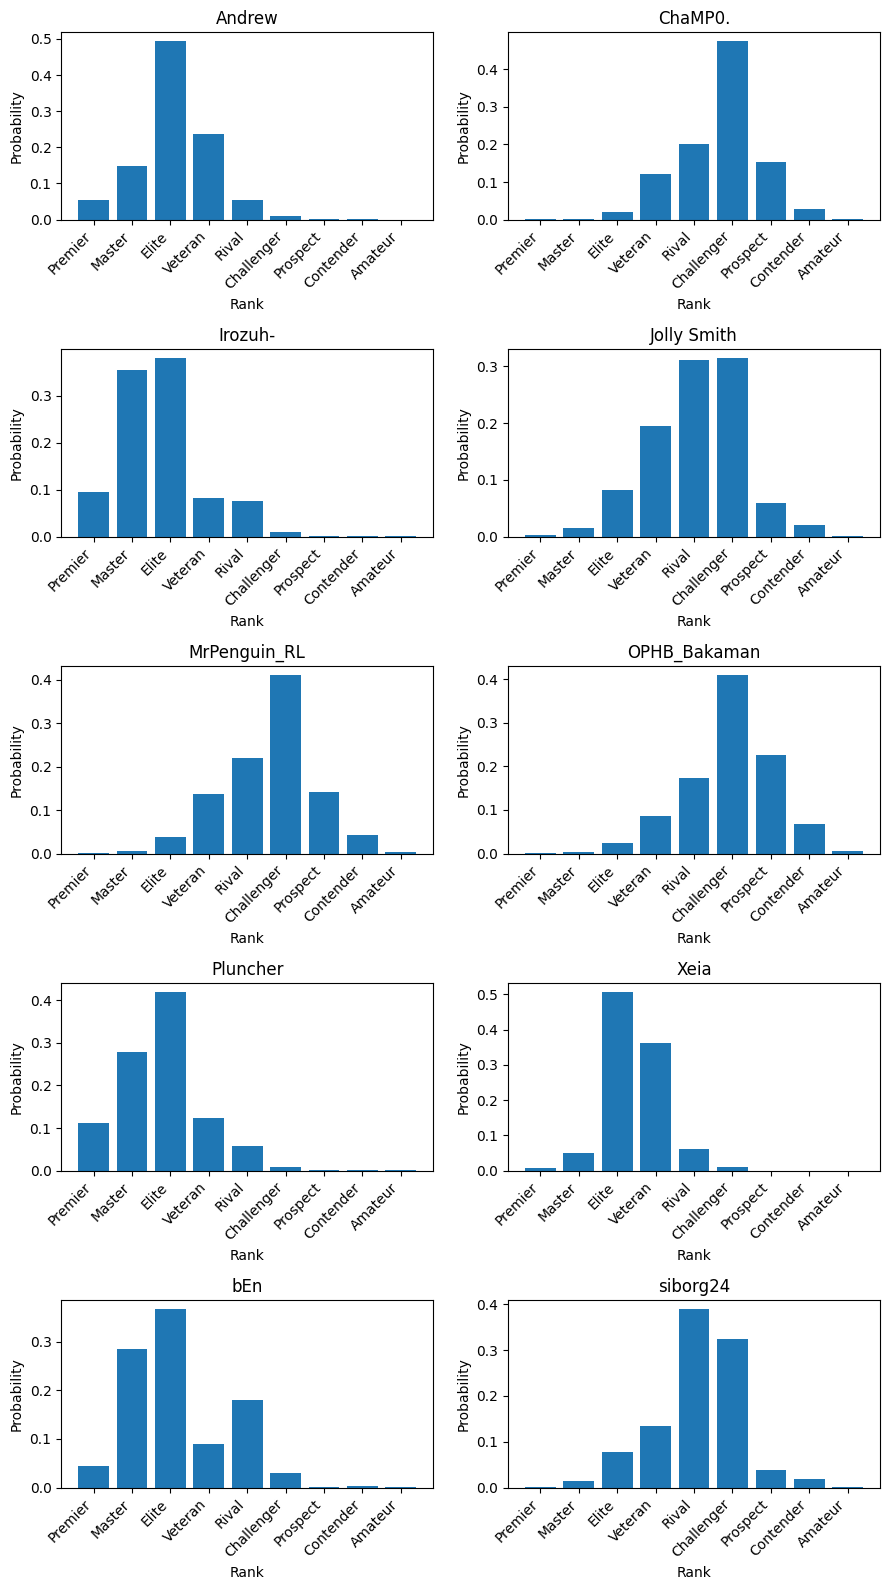

In [10]:
#@title Run Prediction
predictions = model.predict(x_scaled, batch_size=None, verbose=1)

classes = [
    "Premier",
    "Master",
    "Elite",
    "Veteran",
    "Rival",
    "Challenger",
    "Prospect",
    "Contender",
    "Amateur"
]

num_classes = len(classes)
num_samples = len(predictions)
num_rows = int(np.ceil(num_samples / 2))
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 16))

for i, pred in enumerate(predictions):
    row_idx = i // num_cols
    col_idx = i % num_cols

    ax = axes[row_idx, col_idx] if num_samples > 1 else axes

    ax.bar(range(num_classes), pred)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Probability')
    ax.set_title(f'{names[i]}')
    ax.set_xticks(range(num_classes))
    ax.set_xticklabels(classes, rotation=45, ha='right')

plt.tight_layout()

plt.show()